# Weather Station Data - cleaned final version 
## Level 1 QC

In [1]:
#import external libraries
import pandas as pd
import os
pd.options.mode.chained_assignment = None  # default='warn'; chained index warning
import numpy as np
import imp
import datetime
import pytz

#plotting
import matplotlib.pyplot as plt
%matplotlib notebook

#import self-written libraries
import LVL1

In [2]:
#Do you want to display plots (slow for large datasets)
show_plots=False #True= show plots
frac=0.1 #fraction of data to show in plots (0.3 = 30%)

** Define Location-Specific Baseline Settings **

In [3]:
#path to level 0 data
Glacier="Wolverine" #or "Gulkana"
Station="990" #or other elevations; this depends on the naming convention of input data
file_label='_15min'
yr='all' #either "all" or the year you want
pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL0/emily/" + Glacier.lower()+ Station+ file_label+"_"+yr+".csv"

#pth=r"Q:\Project Data\GlacierData\Benchmark_Program\Data\Wolverine\AllYears\Wx\LVL0\emily\wolverine990_2017_15minL0.csv"

#time format and column
UTC_time_column_name='UTC_time'
local_time_column_name='AK_time'
date_format='%Y/%m/%d %H:%M'
timezone='America/Anchorage' #choose from pytz.all_timezones

#directory to save output data
save_pth=r"Q:/Project Data/GlacierData/Benchmark_Program/Data/" +Glacier+ r"/AllYears/Wx/LVL1/emily/" + Glacier.lower()+Station+file_label+yr+".csv"

#Columns which contain precipitation data
precip_columns=['TPGCumulative', 'StageCumulative']

### Data import
- read in data 
- set timezone
- set time as index

In [4]:
#read in level0 CSV
dat=pd.read_csv(pth)
print("read data from: "+ pth)

#Set local time to dataframe index
dat['local_time']=pd.to_datetime(dat[local_time_column_name], format=date_format)
dat=dat.set_index('local_time')
dat=dat.tz_localize(timezone, ambiguous='infer')

read data from: Q:/Project Data/GlacierData/Benchmark_Program/Data/Wolverine/AllYears/Wx/LVL0/emily/wolverine990_15min_all.csv


Station-specific Data Adjustments

In [5]:
# Wolverine990 and Gulkana 1480: Prior to April 2014, asp. temperature only aspirated on the hour; other msmts set to NAN
if Glacier+Station=="Wolverine990":
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/24 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan
    
if Glacier+Station=="Gulkana1480":
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated1']=np.nan
    dat.loc[(dat.index<'2014/04/18 00:00:00') & (dat.index.minute!=0), 'TAspirated2']=np.nan

In [6]:
#Time subset for trouble-shooting
# dat=dat['2016':]
# for precip_col in precip_columns:
#     dat[precip_col]=dat[precip_col]-dat[precip_col][0]

** Remove malfunctioning sensors manually **
* done separately for each timestep entered on look-up table

In [7]:
#read in table listing sensors and timeperiods that need to be modified
pth_bad_sensor_dates=r"Q:\Project Data\GlacierData\Benchmark_Program\Metadata\weather"
bad_sensor_dates_dat=pd.read_excel(os.path.join(pth_bad_sensor_dates, Glacier+Station+"_SensorLog.xlsx"))

#Set bad data to NAN. Move sensor data to correct column, if neccessary.
dat=LVL1.remove_malfunctioning_sensor_data(dat, bad_sensor_dates_dat)
print("Removed:")
bad_sensor_dates_dat

Removed:


,Sensor,Start_Date,End_Date,Action,Correct_Label,Location,Comment
0,TAspirated2,2014-04-25 06:45:00,2014-09-04 09:00:00,switch_label,Tpassive2,Wolverine990,mislabeled
1,Tpassive1,2013-05-07 02:15:00,2013-11-06 08:00:00,bad,NaN,Wolverine990,NaN
2,Tpassive2,2013-11-06 08:00:00,2014-09-04 09:15:00,bad,NaN,Wolverine990,NaN
3,Tpassive2,2016-07-12 16:00:00,2016-08-18 03:59:00,bad,NaN,Wolverine990,NaN
4,TPGCumulative,2010-01-01 00:00:00,2011-10-21 15:00:00,bad,NaN,Wolverine990,slow drain
5,StageCumulative,2010-09-15 00:00:00,2010-10-03 00:00:00,bad,NaN,Wolverine990,slow drain


** Set hard-coded cutoff values** (station specific)

In [8]:
if Glacier+Station=="Wolverine990":
    low_temp_cutoff=-40.0 #deg. C
    high_temp_cutoff=30.0

    precip_high_cutoff=0.015 *1000.#meters
    precip_drain_cutoff=-0.015 *1000.
    obvious_error_precip_cutoff=0.20 *1000. #if 20 cm in 15 minutes, obviously an error. (7/2016 has a drain of only 24 cm)
    
    noise_limit=0.0025 *1000.
    
    Stage_dies='2015/09/01 06:30:00' #time at which instrument was removed
    TPG_born='2012/10/02 00:00:00' #time at which instrument was removed
    
if Glacier + Station== "Gulkana1480":
    low_temp_cutoff=-40
    high_temp_cutoff=30

    precip_high_cutoff=0.015 *1000#in meters
    precip_drain_cutoff=-0.015 *1000
    obvious_error_precip_cutoff=0.15 *1000#if 15 cm in 15 minutes, obviously an error.
    noise_limit=0.0025 *1000
    
    Stage_dies='2015/09/25 11:30:00' #time at which instrument was removed
    TPG_born='2011/07/15 18:30:00' #time at which instrument was removed

In [9]:
#Convert units in precipitation columns from meters to mm
# Neccessary to do early, due to floating-point number limitations
for precip_col in precip_columns:
    dat.loc[:,precip_col]=dat[precip_col]*1000

In [10]:
#Set gages to NAN, when not installed (single gauge style does not cover period of record)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper(): #this is the current precip gage
        dat.loc[:TPG_born, precip_col]=np.nan
        dat.loc[TPG_born:, precip_col]=dat[precip_col].interpolate(method='linear', limit=96) #fill short gaps in record, < 1day
    if 'stage' in precip_col.lower(): #this is old precip gage
        dat.loc[Stage_dies:, precip_col]=np.nan
        dat.loc[:Stage_dies, precip_col]=dat[precip_col].interpolate(method='linear', limit=96) #fill short gaps in record, <1 day

In [11]:
#Save unaltered data for later comparrison with edits
dat_original=dat.copy()

** Clean Temperature Data**

In [12]:
#Temperature
temp_columns=['Tpassive1', 'Tpassive2', 'TAspirated1', 'TAspirated2']
for temp_col in temp_columns:
    temps=dat.loc[:,temp_col]
    dat.loc[:,temp_col]=LVL1.remove_error_temperature_values(temps, low_temp_cutoff, high_temp_cutoff)

#### Plot temperature data, before and after

In [13]:
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original.sample(frac=0.2), df_new=dat.sample(frac=0.2), data_col_name='TAspirated1')

#### Clean Wind Direction Data

In [14]:
wind_dir_columns=['WindDir', 'VecAvgWindDir']
for col in wind_dir_columns:
    dat.loc[dat[col]>360, col]=np.nan #Nonsensical; at wolverine990, this is only 3 days; results from mis-pogramming of logger

** Plot original precipitation data**

In [15]:
#Precip
if show_plots:
    dat_original=dat_original[precip_columns] #subset to only precip columns
    dat_original.sample(frac=frac).plot()

** Remove Gauge Drain and Fill Maintenance **

In [16]:
#Remove unrealistically large instantaneous jumps; create continuous timreseries
for precip_col in precip_columns:
    print(precip_col)
    dat.loc[:,precip_col]=LVL1.precip_remove_drain_and_fill(dat_original[precip_col], obvious_error_precip_cutoff=obvious_error_precip_cutoff, n_cut=4)
dat_step0=dat[precip_columns].copy() #save for plotting

TPGCumulative
Gage Drain/ Fill Event on 2013-08-28
Gage Drain/ Fill Event on 2013-11-06
Gage Drain/ Fill Event on 2014-06-28
Gage Drain/ Fill Event on 2014-06-28
Gage Drain/ Fill Event on 2014-09-04
Gage Drain/ Fill Event on 2015-03-16
Gage Drain/ Fill Event on 2015-03-16
Gage Drain/ Fill Event on 2015-03-16
Gage Drain/ Fill Event on 2015-03-17
Gage Drain/ Fill Event on 2015-03-17
Gage Drain/ Fill Event on 2015-03-17
Gage Drain/ Fill Event on 2015-03-17
Gage Drain/ Fill Event on 2015-03-18
Gage Drain/ Fill Event on 2015-03-18
Gage Drain/ Fill Event on 2015-09-01
Gage Drain/ Fill Event on 2016-02-18
Gage Drain/ Fill Event on 2016-05-10
Gage Drain/ Fill Event on 2016-07-13
Gage Drain/ Fill Event on 2016-07-13
Gage Drain/ Fill Event on 2016-09-09
Gage Drain/ Fill Event on 2016-12-21
Gage Drain/ Fill Event on 2017-04-28
Gage Drain/ Fill Event on 2017-04-28
STOP! Series contains NANs, which will result in unintended jumps in cumulative timeseries!
StageCumulative
Gage Drain/ Fill Event on 2

<IPython.core.display.Javascript object>


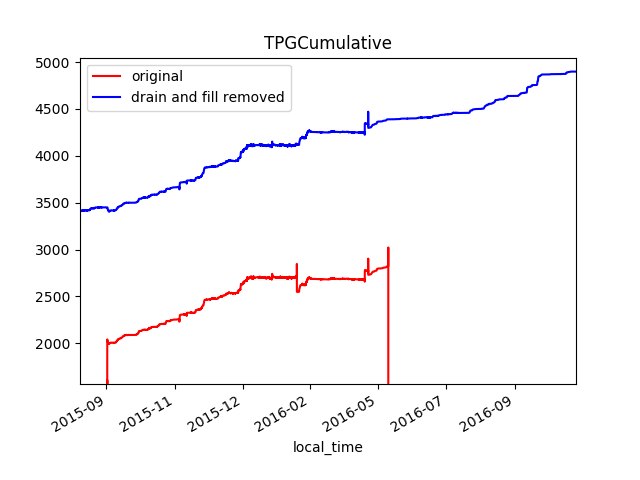

In [34]:
#Plot
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[0], label_old="original", label_new="drain and fill removed")

In [18]:
dPrecip=dat_step0.TPGCumulative-dat_step0.TPGCumulative.shift(1)

In [19]:
dPrecip['2016-07-13'].min()

-0.8000000000001819

In [20]:
#Plot older precip gage
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_original, df_new=dat_step0, data_col_name=precip_columns[1], label_old="original", label_new="drain and fill removed")

In [21]:
#Fill any remaining gaps due to sensor fallout, etc: 
for precip_col in precip_columns:
    dat_step0.loc[:,precip_col]=LVL1.precip_interpolate_gaps_under1day(dat_step0[precip_col])

#### Remove high-amplitude noise related to wind

In [22]:
#Remove high-amplitude noise, related to wind, etc.
imp.reload(LVL1)
for precip_col in precip_columns:
    print(precip_col)
    dat.loc[:, precip_col]=LVL1.precip_remove_high_frequency_noiseNayak2010(dat_step0[precip_col], noise=noise_limit, bucket_fill_drain_cutoff=obvious_error_precip_cutoff, n_forward_noise_free=10)
dat_step1=dat[precip_columns].copy() #save for plotting

TPGCumulative
STOP! Series contains NANs, which will result in unintended jumps in cumulative timeseries!
StageCumulative
STOP! Series contains NANs, which will result in unintended jumps in cumulative timeseries!


In [23]:
#Plot results
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step0.sample(frac=0.3), df_new=dat_step1.sample(frac=0.3), data_col_name=precip_columns[0], label_old="original", label_new="high amplitude noise removed")

In [24]:
#Strip Remaining Outlier Values with Hampel Filter
for precip_col in precip_columns:
    dat.loc[:,precip_col]=LVL1.hampel(dat_step1[precip_col])
dat_step2=dat[precip_columns].copy() #save for plotting

In [25]:
#Plot results
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step1.sample(frac=frac), df_new=dat_step2.sample(frac=frac), data_col_name=precip_columns[0], label_old="original", label_new="after hampel outlier filter")

In [26]:
#Interpolate gaps under one day in length
# for precip_col in precip_columns:
#     dat[precip_col]=LVL1.precip_interpolate_gaps_under1day(dat_step2[precip_col])

**Smooth Data with method from Nayak (2010): **

In [27]:
#Smooth Incremental Precip Data
for precip_col in precip_columns:
    #Smooth this data with method from Nayak 2010
    print ("smoothing "+ precip_col)
    dat[precip_col]=LVL1.smooth_precip_Nayak2010(dat_step2[precip_col])
dat_step3=dat[precip_columns].copy() #save for plotting

smoothing TPGCumulative
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute
STOP! Series contains NANs, which will result in unintended jumps in cumulative timeseries!
smoothing StageCumulative
  smoothing data in forward direction; may take a minute
  smoothing data in reverse direction; may take a minute
STOP! Series contains NANs, which will result in unintended jumps in cumulative timeseries!


In [28]:
#Plot
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step2, df_new=dat_step3, data_col_name=precip_columns[0], label_old="original", label_new="after smoothing")

In [29]:
if show_plots:
    %matplotlib notebook
    LVL1.plot_comparrison(df_old=dat_step2.sample(frac=frac), df_new=dat_step3.sample(frac=frac), data_col_name=precip_columns[1], label_old="original", label_new="after smoothing")

In [30]:
#Final Comparrison Plot
if show_plots:
    %matplotlib notebook
    frac=0.1
    ax=dat_original[precip_columns[0]].sample(frac=frac).plot(color='black', label='original')
    dat_step0[precip_columns[0]].sample(frac=frac).plot(color='blue', ax=ax, label='fills removed')
    dat_step3[precip_columns[0]].sample(frac=frac).plot(color='red', ax=ax, label='final')
    plt.legend()

Final Steps

In [31]:
#Set no-data values before TPG installed, and after rocket removed to NAN (not 0)
for precip_col in precip_columns:
    if 'TPG' in precip_col.upper():
        dat.loc[:TPG_born, precip_col]=np.nan
    if 'stage' in precip_col.lower():
        dat.loc[Stage_dies:, precip_col]=np.nan

## Save Edited Data

In [32]:
#Create time as text column
local_timezone=pytz.timezone(timezone) #create local timezone object (e.g. AK time)
dat['Local_time']=dat.index.tz_convert(local_timezone).strftime(date_format)#Create column for true local time (as string, not UTC - X hrs)
#Column Names
out_columns=['Local_time']+temp_columns+precip_columns+wind_dir_columns+['WindSpeed', 'WindGustSpeed','RelHum', 'LoggerTemp','LoggerBattery']
#Subset
save_dat=dat[out_columns] #removes unwanted columns

#Save
save_dat.to_csv(save_pth, index=False, float_format='%g')
#save_dat.to_csv(index=False, float_format='%g')
